In [8]:
import numpy as np
from type_definitions.utils import *

In [9]:
seed = 100

In [10]:
np.random.seed(seed)

cases = generate_acasxu_cases(100)
results = evaluate_acasxu_cases(cases)
# Extract ownship trajectories (aircraft 0) from valid results
trajectories = [
    extract_acasxu_trajectory(r, aircraft_index=0)
    for r in results
    if not r.simulation_failed
]
valid_results = [r for r in results if not r.simulation_failed]
print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Collisions: {sum(1 for r in valid_results if r.collision_occurred)}, Safe: {sum(1 for r in valid_results if not r.collision_occurred)}"
)
print(f"Min separation: {min([r.min_separation for r in valid_results]):.2f} ft")
print(
    f"Average min separation: {np.mean([r.min_separation for r in valid_results]):.2f} ft"
)

Generated 100 valid trajectories
Collisions: 0, Safe: 100
Min separation: 4003.99 ft
Average min separation: 21430.38 ft


In [11]:
# Analyze collision scenarios
collision_results = [r for r in valid_results if r.collision_occurred]
print(f"Collision scenarios: {len(collision_results)}")
if len(collision_results) > 0:
    print(
        f"  Average min separation in collisions: {np.mean([r.min_separation for r in collision_results]):.2f} ft"
    )
    print(
        f"  Min separation in collisions: {min([r.min_separation for r in collision_results]):.2f} ft"
    )

# Analyze safe scenarios
safe_results = [r for r in valid_results if not r.collision_occurred]
print(f"\nSafe scenarios: {len(safe_results)}")
if len(safe_results) > 0:
    print(
        f"  Average min separation: {np.mean([r.min_separation for r in safe_results]):.2f} ft"
    )
    print(f"  Min separation: {min([r.min_separation for r in safe_results]):.2f} ft")
    print(f"  Max separation: {max([r.min_separation for r in safe_results]):.2f} ft")

# Check for safety limit violations
violated_results = [r for r in valid_results if r.violated_safety_limits]
print(f"\nSafety limit violations: {len(violated_results)}")

Collision scenarios: 0

Safe scenarios: 100
  Average min separation: 21430.38 ft
  Min separation: 4003.99 ft
  Max separation: 34572.48 ft

Safety limit violations: 0


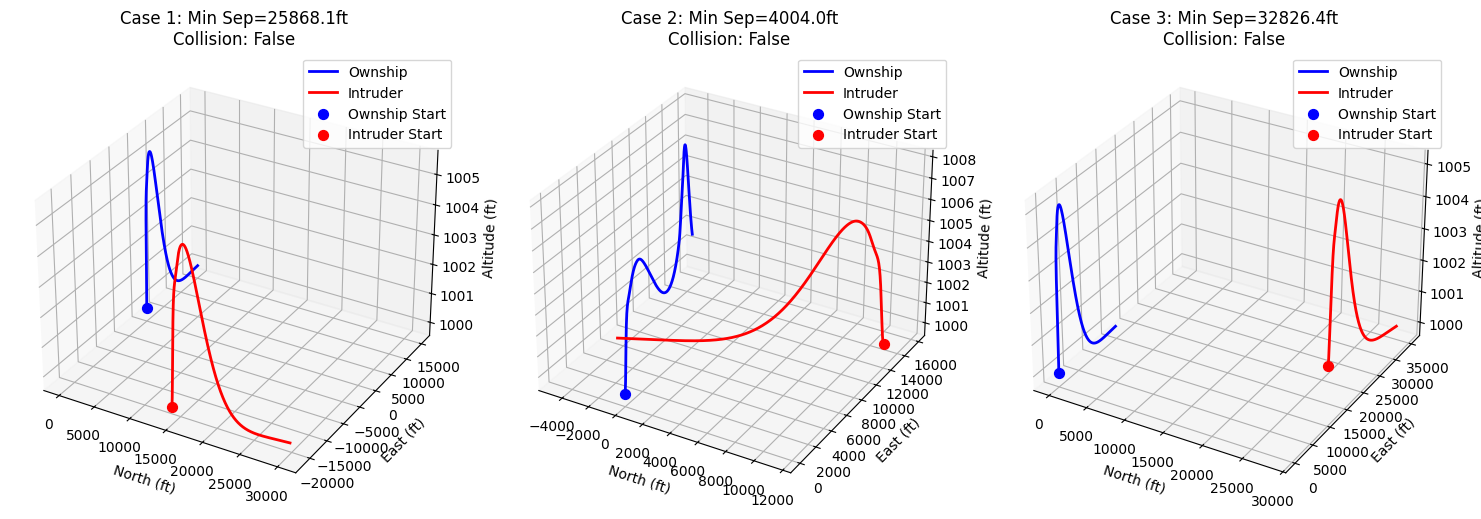

In [12]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot a few example trajectories (ownship and intruder)
fig = plt.figure(figsize=(15, 5))
num_examples = min(3, len(valid_results))

for idx in range(num_examples):
    result = valid_results[idx]
    if len(result.aircraft_trajectories) >= 2:
        ax = fig.add_subplot(1, num_examples, idx + 1, projection="3d")

        ownship_traj = result.aircraft_trajectories[0]
        intruder_traj = result.aircraft_trajectories[1]

        # Plot trajectories
        ax.plot(
            ownship_traj[:, 0],
            ownship_traj[:, 1],
            ownship_traj[:, 2],
            "b-",
            label="Ownship",
            linewidth=2,
        )
        ax.plot(
            intruder_traj[:, 0],
            intruder_traj[:, 1],
            intruder_traj[:, 2],
            "r-",
            label="Intruder",
            linewidth=2,
        )

        # Mark start and end points
        ax.scatter(
            ownship_traj[0, 0],
            ownship_traj[0, 1],
            ownship_traj[0, 2],
            c="blue",
            marker="o",
            s=50,
            label="Ownship Start",
        )
        ax.scatter(
            intruder_traj[0, 0],
            intruder_traj[0, 1],
            intruder_traj[0, 2],
            c="red",
            marker="o",
            s=50,
            label="Intruder Start",
        )

        ax.set_xlabel("North (ft)")
        ax.set_ylabel("East (ft)")
        ax.set_zlabel("Altitude (ft)")
        ax.set_title(
            f"Case {idx+1}: Min Sep={result.min_separation:.1f}ft\n"
            f"Collision: {result.collision_occurred}"
        )
        ax.legend()

plt.tight_layout()
plt.show()

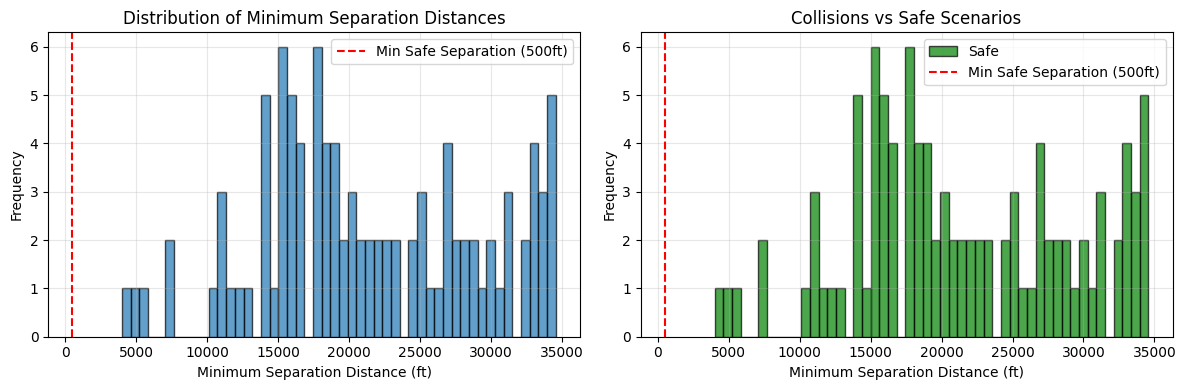

In [13]:
# Plot separation distance histogram
separations = [r.min_separation for r in valid_results]
collision_separations = (
    [r.min_separation for r in collision_results] if len(collision_results) > 0 else []
)
safe_separations = [r.min_separation for r in safe_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of all separations
ax1.hist(separations, bins=50, alpha=0.7, edgecolor="black")
ax1.axvline(500, color="r", linestyle="--", label="Min Safe Separation (500ft)")
ax1.set_xlabel("Minimum Separation Distance (ft)")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Minimum Separation Distances")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Separate histograms for collisions vs safe
if len(collision_separations) > 0:
    ax2.hist(
        collision_separations,
        bins=20,
        alpha=0.7,
        label="Collisions",
        color="red",
        edgecolor="black",
    )
if len(safe_separations) > 0:
    ax2.hist(
        safe_separations,
        bins=50,
        alpha=0.7,
        label="Safe",
        color="green",
        edgecolor="black",
    )
ax2.axvline(500, color="r", linestyle="--", label="Min Safe Separation (500ft)")
ax2.set_xlabel("Minimum Separation Distance (ft)")
ax2.set_ylabel("Frequency")
ax2.set_title("Collisions vs Safe Scenarios")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

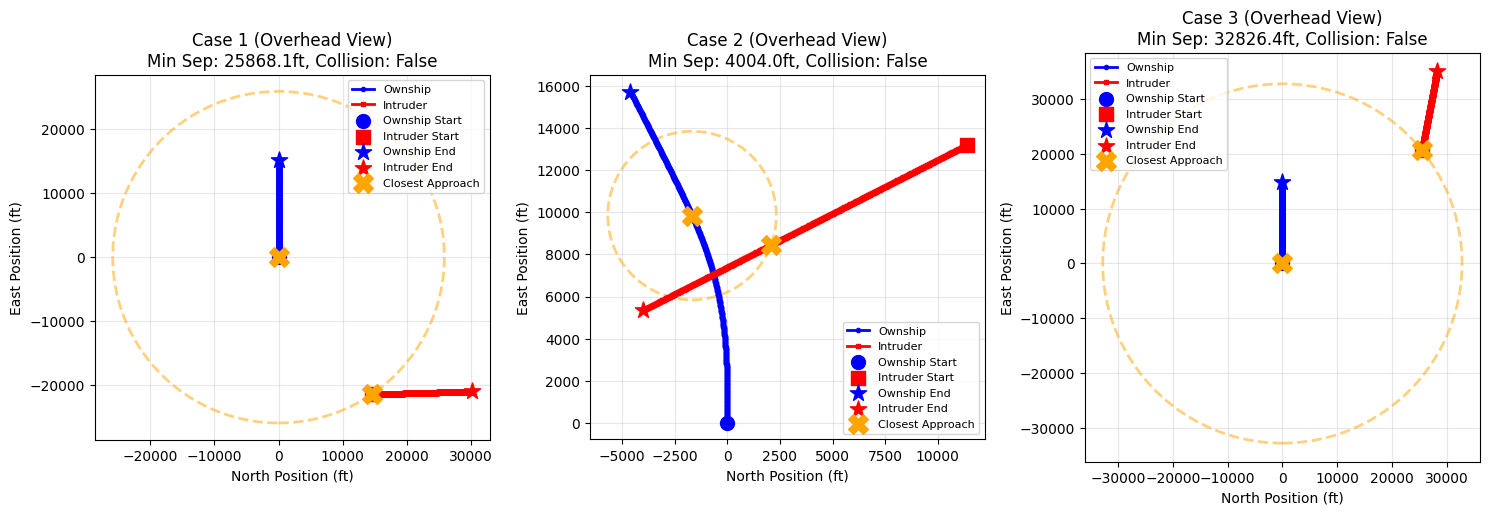

In [14]:
from matplotlib.patches import Circle

# Plot 2D overhead view of trajectories
fig = plt.figure(figsize=(15, 5))
num_examples = min(3, len(valid_results))

for idx in range(num_examples):
    result = valid_results[idx]
    if len(result.aircraft_trajectories) >= 2:
        ax = fig.add_subplot(1, num_examples, idx + 1)

        ownship_traj = result.aircraft_trajectories[0]
        intruder_traj = result.aircraft_trajectories[1]

        # Plot 2D trajectories (north vs east)
        ax.plot(
            ownship_traj[:, 0],
            ownship_traj[:, 1],
            "b-",
            label="Ownship",
            linewidth=2,
            marker="o",
            markersize=3,
        )
        ax.plot(
            intruder_traj[:, 0],
            intruder_traj[:, 1],
            "r-",
            label="Intruder",
            linewidth=2,
            marker="s",
            markersize=3,
        )

        # Mark start points
        ax.scatter(
            ownship_traj[0, 0],
            ownship_traj[0, 1],
            c="blue",
            marker="o",
            s=100,
            label="Ownship Start",
            zorder=5,
        )
        ax.scatter(
            intruder_traj[0, 0],
            intruder_traj[0, 1],
            c="red",
            marker="s",
            s=100,
            label="Intruder Start",
            zorder=5,
        )

        # Mark end points
        ax.scatter(
            ownship_traj[-1, 0],
            ownship_traj[-1, 1],
            c="blue",
            marker="*",
            s=150,
            label="Ownship End",
            zorder=5,
        )
        ax.scatter(
            intruder_traj[-1, 0],
            intruder_traj[-1, 1],
            c="red",
            marker="*",
            s=150,
            label="Intruder End",
            zorder=5,
        )

        # Find and mark closest approach
        ownship_pos = ownship_traj[:, :2]
        intruder_pos = intruder_traj[:, :2]
        distances = np.sqrt(np.sum((ownship_pos - intruder_pos) ** 2, axis=1))
        min_idx = np.argmin(distances)
        ax.scatter(
            ownship_pos[min_idx, 0],
            ownship_pos[min_idx, 1],
            c="orange",
            marker="X",
            s=200,
            label="Closest Approach",
            zorder=6,
        )
        ax.scatter(
            intruder_pos[min_idx, 0],
            intruder_pos[min_idx, 1],
            c="orange",
            marker="X",
            s=200,
            zorder=6,
        )

        # Draw circle at minimum separation
        circle = Circle(
            (ownship_pos[min_idx, 0], ownship_pos[min_idx, 1]),
            result.min_separation,
            fill=False,
            color="orange",
            linestyle="--",
            linewidth=2,
            alpha=0.5,
        )
        ax.add_patch(circle)

        ax.set_xlabel("North Position (ft)")
        ax.set_ylabel("East Position (ft)")
        ax.set_title(
            f"Case {idx+1} (Overhead View)\n"
            f"Min Sep: {result.min_separation:.1f}ft, "
            f"Collision: {result.collision_occurred}"
        )
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_aspect("equal")

plt.tight_layout()
plt.show()